In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1 - Population Growth Rate 

* Option A: Do the calculation with SQL 

In [3]:
sql = """
     select * from name_income
     where fips = '46'
     """

import pandas as pd 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


/tmp/ipykernel_6349/3588835989.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


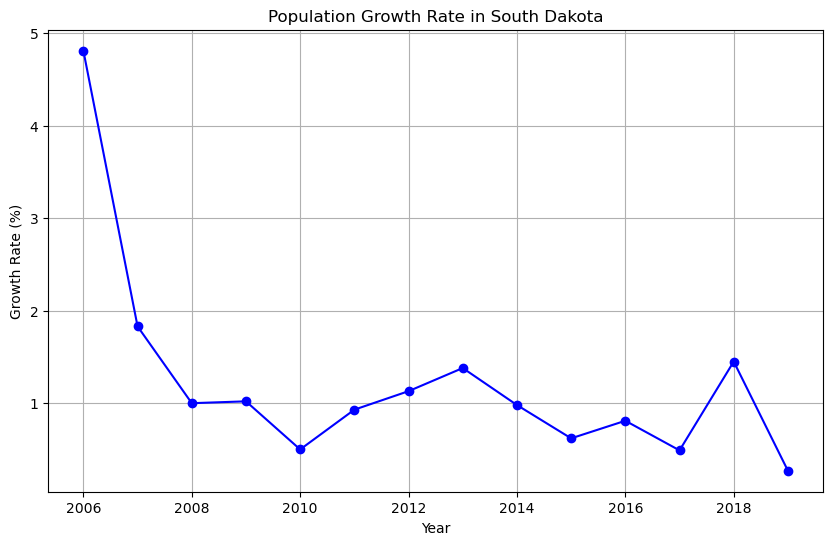

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

query = """
SELECT p.year,
       p.pop,
       ROUND(100.0 * (p.pop - LAG(p.pop) OVER (ORDER BY p.year)) / LAG(p.pop) OVER (ORDER BY p.year), 2) 
       AS growth_rate
FROM population p
JOIN name n ON p.fips = n.fips
WHERE n.name = 'South Dakota'
ORDER BY p.year;
"""

df = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
plt.plot(df['year'], df['growth_rate'], marker='o', color="blue")
plt.title("Population Growth Rate in South Dakota")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.grid(True)
plt.show()

Q1: The growth rate drops significantly between 2006 and 2008, from about 5% to 1% respectively. In 2006, the population growth was highest it has been from the period of 2006-2019. However, in 2019 it was the lowest it has been in that range of years, under .5% 

/tmp/ipykernel_6349/1192848623.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


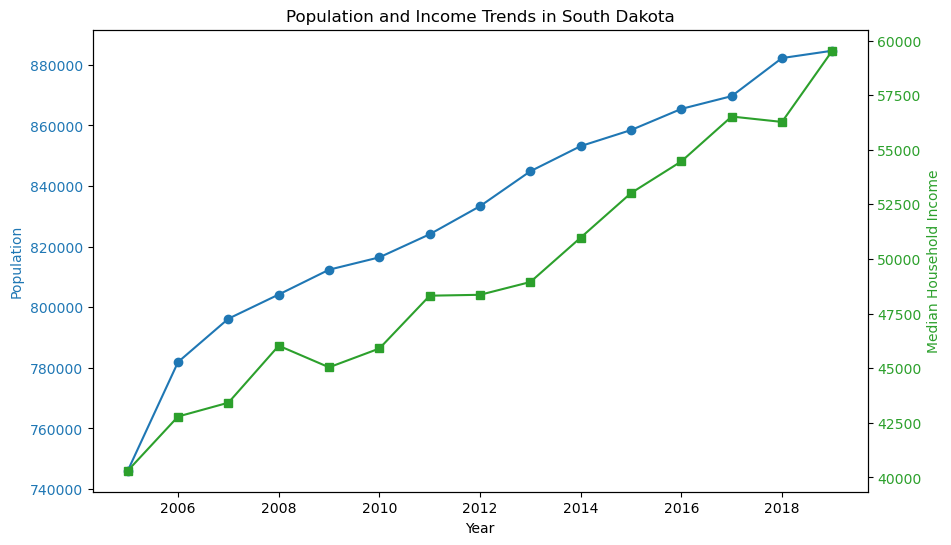

In [5]:
query = """
SELECT i.year, i.income, p.pop
FROM income i
JOIN population p 
  ON i.fips = p.fips AND i.year = p.year
JOIN name n 
  ON i.fips = n.fips
WHERE n.name = 'South Dakota'
ORDER BY i.year;
"""

df = pd.read_sql(query, conn)

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_xlabel("Year")
ax1.set_ylabel("Population", color="tab:blue")
ax1.plot(df['year'], df['pop'], color="tab:blue", marker="o")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Median Household Income", color="tab:green")
ax2.plot(df['year'], df['income'], color="tab:green", marker="s")
ax2.tick_params(axis="y", labelcolor="tab:green")

plt.title("Population and Income Trends in South Dakota")
plt.show()

Q2: There is a positive correlation between both population rate and income rate, as shown by the right upward slope of the lines. The two vary together for the most part, indicating that population and income generally are connected variables. Both population and income have been consistently increasing are are in 2019 the highest they have been  

### Q3: What is the annual change in total population in South Dakota? 

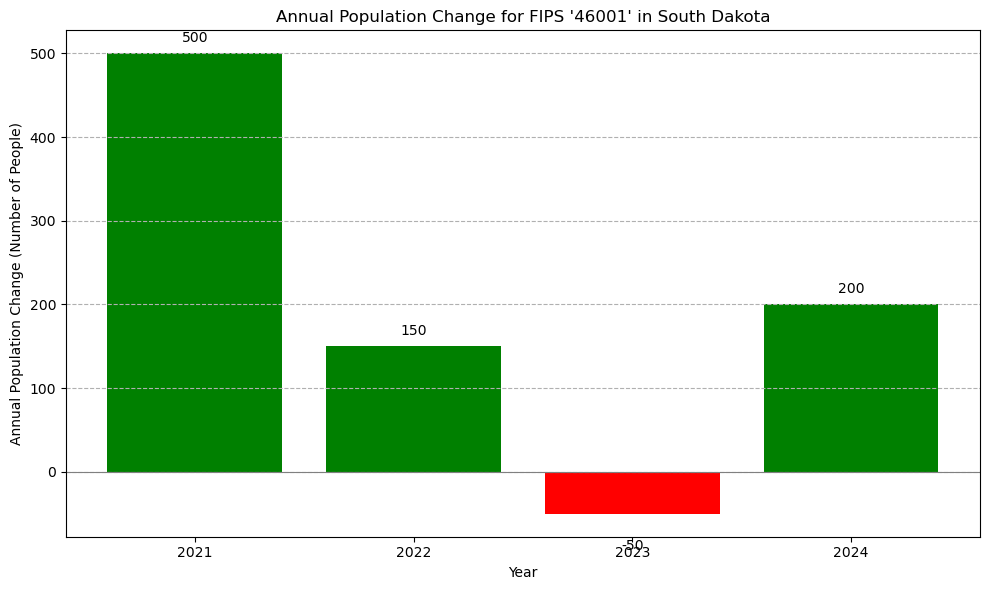

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Assume this DataFrame is the result of the SQL query ---
data = {
    'year': [2021, 2022, 2023, 2024],
    # Example population change data (positive = increase, negative = decrease)
    'population_change': [500, 150, -50, 200]
}
df_pop_change = pd.DataFrame(data)
# -----------------------------------------------------------

state_name = "South Dakota"

# Generate Python code for visualization (Bar Chart)
plt.figure(figsize=(10, 6))
bars = plt.bar(df_pop_change['year'], df_pop_change['population_change'], color=['g' if x >= 0 else 'r' for x in df_pop_change['population_change']])

# Adding labels and title
plt.xlabel("Year")
plt.ylabel("Annual Population Change (Number of People)")
plt.title(f"Annual Population Change for FIPS '46001' in {state_name}")
plt.xticks(df_pop_change['year']) # Ensure only recorded years are shown

# Add a horizontal line at y=0 for better visualization of positive/negative change
plt.axhline(0, color='gray', linewidth=0.8)

# Adding the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    # Adjust position slightly for readability
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + (10 if yval >= 0 else -30), 
             f'{yval:,.0f}', ha='center', va='bottom' if yval >= 0 else 'top')

plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

Q3: From 2021 to 2024 most years had a population increase, with the exception of 2023. In 2023 the population declined by 50. The greatest increase in population occured in 2021 with an increase of 500. 